<a href="https://colab.research.google.com/github/GeorgeEngland/ALGOS/blob/master/(Meta)_labelling_and_the_Triple_Barrier_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Article:

Installing and Importing Requisite Packages


In [11]:
pip install dask[dataframe] --upgrade

     |████████████████████████████████| 132 kB 48.3 MB/s 


In [12]:
%load_ext autoreload
%autoreload 2
# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
import datetime as dt
import multiprocessing as mp
from datetime import datetime
from collections import OrderedDict as od
import re
import os
import json
os.environ['THEANO_FLAGS'] = 'device=cpu,floatX=float32'

# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
from pandas import Timestamp
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
import pymc3 as pm
from theano import shared, theano as tt
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from itertools import cycle
from scipy import interp

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.style.use('seaborn-talk')
plt.style.use('bmh')

#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
#plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import missingno as msno
from google.colab import drive

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Defining Necessary Functions

In [13]:
from datetime import datetime, timedelta

#'close, high, low, open, time, vol'
def get_dollar_bars(time_bars, dollar_threshold):

    # initialize an empty list of dollar bars
    dollar_bars = []

    # initialize the running dollar volume at zero
    running_volume = 0

    # initialize the running high and low with placeholder values
    running_high, running_low = 0, math.inf

    # for each time bar...
    for i in tqdm(range(len(time_bars))):

        # get the timestamp, open, high, low, close, and volume of the next bar
        next_close, next_high, next_low, next_open, next_timestamp, next_volume = time_bars['close'][i],time_bars['high'][i],time_bars['low'][i],time_bars['open'][i],time_bars.index[i],time_bars['volume'][i]

        # get the midpoint price of the next bar (the average of the open and the close)
        midpoint_price = ((next_open) + (next_close))/2

        # get the approximate dollar volume of the bar using the volume and the midpoint price
        dollar_volume = next_volume * midpoint_price

        # update the running high and low
        running_high, running_low = max(running_high, next_high), min(running_low, next_low)

        # if the next bar's dollar volume would take us over the threshold...
        if dollar_volume + running_volume >= dollar_threshold:

            # set the timestamp for the dollar bar as the timestamp at which the bar closed (i.e. one minute after the timestamp of the last minutely bar included in the dollar bar)
            bar_timestamp = next_timestamp + timedelta(minutes=1)
            
            # add a new dollar bar to the list of dollar bars with the timestamp, running high/low, and next close
            dollar_bars += [{'timestamp': bar_timestamp, 'open': next_open, 'high': running_high, 'low': running_low, 'close': next_close}]

            # reset the running volume to zero
            running_volume = 0

            # reset the running high and low to placeholder values
            running_high, running_low = 0, math.inf

        # otherwise, increment the running volume
        else:
            running_volume += dollar_volume

    # return the list of dollar bars
    return dollar_bars

In [14]:
class MultiProcessingFunctions:
	""" This static functions in this class enable multi-processing"""
	def __init__(self):
		pass

	@staticmethod
	def lin_parts(num_atoms, num_threads):
		""" This function partitions a list of atoms in subsets (molecules) of equal size.
		An atom is a set of indivisible set of tasks.
		"""

		# partition of atoms with a single loop
		parts = np.linspace(0, num_atoms, min(num_threads, num_atoms) + 1)
		parts = np.ceil(parts).astype(int)
		return parts

	@staticmethod
	def nested_parts(num_atoms, num_threads, upper_triangle=False):
		""" This function enables parallelization of nested loops.
		"""
		# partition of atoms with an inner loop
		parts = []
		num_threads_ = min(num_threads, num_atoms)

		for num in range(num_threads_):
			part = 1 + 4 * (parts[-1] ** 2 + parts[-1] + num_atoms * (num_atoms + 1.) / num_threads_)
			part = (-1 + part ** .5) / 2.
			parts.append(part)

		parts = np.round(parts).astype(int)

		if upper_triangle:  # the first rows are heaviest
			parts = np.cumsum(np.diff(parts)[::-1])
			parts = np.append(np.array([0]), parts)
		return parts

	@staticmethod
	def mp_pandas_obj(func, pd_obj, num_threads=24, mp_batches=1, lin_mols=True, **kargs):
		"""	
		:param func: (string) function to be parallelized
		:param pd_obj: (vector) Element 0, is name of argument used to pass the molecule;
						Element 1, is the list of atoms to be grouped into a molecule
		:param num_threads: (int) number of threads
		:param mp_batches: (int) number of batches
		:param lin_mols: (bool) Tells if the method should use linear or nested partitioning
		:param kargs: (var args)
		:return: (data frame) of results
		"""

		if lin_mols:
			parts = MultiProcessingFunctions.lin_parts(len(pd_obj[1]), num_threads * mp_batches)
		else:
			parts = MultiProcessingFunctions.nested_parts(len(pd_obj[1]), num_threads * mp_batches)

		jobs = []
		for i in range(1, len(parts)):
			job = {pd_obj[0]: pd_obj[1][parts[i - 1]:parts[i]], 'func': func}
			job.update(kargs)
			jobs.append(job)

		if num_threads == 1:
			out = MultiProcessingFunctions.process_jobs_(jobs)
		else:
			out = MultiProcessingFunctions.process_jobs(jobs, num_threads=num_threads)

		if isinstance(out[0], pd.DataFrame):
			df0 = pd.DataFrame()
		elif isinstance(out[0], pd.Series):
			df0 = pd.Series()
		else:
			return out

		for i in out:
			df0 = df0.append(i)

		df0 = df0.sort_index()
		return df0

	@staticmethod
	def process_jobs_(jobs):
		""" Run jobs sequentially, for debugging """
		out = []
		for job in jobs:
			out_ = MultiProcessingFunctions.expand_call(job)
			out.append(out_)
		return out

	@staticmethod
	def expand_call(kargs):
		""" Expand the arguments of a callback function, kargs['func'] """
		func = kargs['func']
		del kargs['func']
		out = func(**kargs)
		return out

	@staticmethod
	def report_progress(job_num, num_jobs, time0, task):
		# Report progress as asynch jobs are completed

		msg = [float(job_num) / num_jobs, (time.time() - time0)/60.]
		msg.append(msg[1] * (1/msg[0] - 1))
		time_stamp = str(dt.datetime.fromtimestamp(time.time()))

		msg = time_stamp + ' ' + str(round(msg[0]*100, 2)) + '% '+task+' done after ' + \
			str(round(msg[1], 2)) + ' minutes. Remaining ' + str(round(msg[2], 2)) + ' minutes.'

		if job_num < num_jobs:
			sys.stderr.write(msg+'\r')
		else:
			sys.stderr.write(msg+'\n')

		return

	@staticmethod
	def process_jobs(jobs, task=None, num_threads=24):
		""" Run in parallel. jobs must contain a 'func' callback, for expand_call"""

		if task is None:
			task = jobs[0]['func'].__name__

		pool = mp.Pool(processes=num_threads)
		# outputs, out, time0 = pool.imap_unordered(MultiProcessingFunctions.expand_call,jobs),[],time.time()
		outputs = pool.imap_unordered(MultiProcessingFunctions.expand_call, jobs)
		out = []
		time0 = time.time()

		# Process asyn output, report progress
		for i, out_ in enumerate(outputs, 1):
			out.append(out_)
			MultiProcessingFunctions.report_progress(i, len(jobs), time0, task)

		pool.close()
		pool.join()  # this is needed to prevent memory leaks
		return out

In [15]:
def get_daily_vol(close, lookback=100):
    """
    :param close: (data frame) Closing prices
    :param lookback: (int) lookback period to compute volatility
    :return: (series) of daily volatility value
    """
    print('Calculating daily volatility for dynamic thresholds')
    
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
        
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

In [16]:
def get_t_events(raw_price, threshold):
    """
    :param raw_price: (series) of close prices.
    :param threshold: (float) when the abs(change) is larger than the threshold, the
    function captures it as an event.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events = []
    s_pos = 0
    s_neg = 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

In [17]:
def add_vertical_barrier(t_events, close, num_days=1):
    """
    :param t_events: (series) series of events (symmetric CUSUM filter)
    :param close: (series) close prices
    :param num_days: (int) maximum number of days a trade can be active
    :return: (series) timestamps of vertical barriers
    """
    t1 = close.index.searchsorted(t_events + pd.Timedelta(days=num_days))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=t_events[:t1.shape[0]])  # NaNs at end
    return t1

In [18]:
def apply_pt_sl_on_t1(close, events, pt_sl, molecule):
    """
    :param close: (series) close prices
    :param events: (series) of indices that signify "events" 
    :param pt_sl: (array) element 0, indicates the profit taking level; 
                          element 1 is stop loss level
    :param molecule: (an array) a set of datetime index values for processing
    :return: (dataframe) timestamps at which each barrier was touched
    """
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if pt_sl[0] > 0:
        pt = pt_sl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index)  # NaNs

    if pt_sl[1] > 0:
        sl = -pt_sl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index)  # NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1]  # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # earliest profit taking

    return out

In [19]:
def get_events(close, t_events, pt_sl, target, min_ret, num_threads, 
              vertical_barrier_times=False, side=None):
    """
    :param close: (series) Close prices
    :param t_events: (series) of t_events. 
                     These are timestamps that will seed every triple barrier.
    :param pt_sl: (2 element array) element 0, indicates the profit taking level; 
                  element 1 is stop loss level.
                  A non-negative float that sets the width of the two barriers. 
                  A 0 value means that the respective horizontal barrier will be disabled.
    :param target: (series) of values that are used (in conjunction with pt_sl)
                   to determine the width of the barrier.
    :param min_ret: (float) The minimum target return required for running a triple barrier search.
    :param num_threads: (int) The number of threads concurrently used by the function.
    :param vertical_barrier_times: (series) A pandas series with the timestamps of the vertical barriers.
    :param side: (series) Side of the bet (long/short) as decided by the primary model
    :return: (data frame) of events
            -events.index is event's starttime
            -events['t1'] is event's endtime
            -events['trgt'] is event's target
            -events['side'] (optional) implies the algo's position side
    """

    # 1) Get target
    target = target.loc[target.index.intersection(t_events)]
    target = target[target > min_ret]  # min_ret

    # 2) Get vertical barrier (max holding period)
    if vertical_barrier_times is False:
        vertical_barrier_times = pd.Series(pd.NaT, index=t_events)

    # 3) Form events object, apply stop loss on vertical barrier
    if side is None:
        side_ = pd.Series(1., index=target.index)
        pt_sl_ = [pt_sl[0], pt_sl[0]]
    else:
        side_ = side.loc[target.index]
        pt_sl_ = pt_sl[:2]

    events = pd.concat({'t1': vertical_barrier_times, 'trgt': target, 'side': side_},
                        axis=1)
    events = events.dropna(subset=['trgt'])

    # Apply Triple Barrier
    df0 = MultiProcessingFunctions.mp_pandas_obj(func=apply_pt_sl_on_t1,
                                                 pd_obj=('molecule', events.index),
                                                 num_threads=num_threads,
                                                 close=close,
                                                 events=events,
                                                 pt_sl=pt_sl_)

    events['t1'] = df0.dropna(how='all').min(axis=1)  # pd.min ignores nan

    if side is None:
        events = events.drop('side', axis=1)

    return events

In [20]:
def barrier_touched(out_df):
    """
    :param out_df: (DataFrame) containing the returns and target
    :return: (DataFrame) containing returns, target, and labels
    """
    store = []
    for i in np.arange(len(out_df)):
        date_time = out_df.index[i]
        ret = out_df.loc[date_time, 'ret']
        target = out_df.loc[date_time, 'trgt']

        if ret > 0.0 and ret > target:
            # Top barrier reached
            store.append(1)
        elif ret < 0.0 and ret < -target:
            # Bottom barrier reached
            store.append(-1)
        else:
            # Vertical barrier reached
            store.append(0)

    out_df['bin'] = store

    return out_df

In [21]:
def get_bins(triple_barrier_events, close):
    """
    :param triple_barrier_events: (data frame)
                -events.index is event's starttime
                -events['t1'] is event's endtime
                -events['trgt'] is event's target
                -events['side'] (optional) implies the algo's position side
                Case 1: ('side' not in events): bin in (-1,1) <-label by price action
                Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    :param close: (series) close prices
    :return: (data frame) of meta-labeled events
    """

    # 1) Align prices with their respective events
    events_ = triple_barrier_events.dropna(subset=['t1'])
    prices = events_.index.union(events_['t1'].values)
    prices = prices.drop_duplicates()
    prices = close.reindex(prices, method='bfill')
    
    # 2) Create out DataFrame
    out_df = pd.DataFrame(index=events_.index)
    # Need to take the log returns, else your results will be skewed for short positions
    out_df['ret'] = np.log(prices.loc[events_['t1'].values].values) - np.log(prices.loc[events_.index])
    out_df['trgt'] = events_['trgt']

    # Meta labeling: Events that were correct will have pos returns
    if 'side' in events_:
        out_df['ret'] = out_df['ret'] * events_['side']  # meta-labeling

    # Added code: label 0 when vertical barrier reached
    out_df = barrier_touched(out_df)

    # Meta labeling: label incorrect events with a 0
    if 'side' in events_:
        out_df.loc[out_df['ret'] <= 0, 'bin'] = 0
    
    # Transform the log returns back to normal returns.
    out_df['ret'] = np.exp(out_df['ret']) - 1
    
    # Add the side to the output. This is useful for when a meta label model must be fit
    tb_cols = triple_barrier_events.columns
    if 'side' in tb_cols:
        out_df['side'] = triple_barrier_events['side']
        
    out_df

    return out_df

In [22]:
def bbands(close_prices, window, no_of_stdev):
    # rolling_mean = close_prices.rolling(window=window).mean()
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

# Implementation

Import and Format Data

In [23]:
# mount personal drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

csv_file = '/content/drive/MyDrive/BTCUSD_1min.csv'


In [26]:
#download the data into your google drive to use the following code
infp=PurePath('/content/drive/MyDrive/BTC_1m_2018_dollar.parq')

#import data and set timestamps as index
data = pd.read_parquet(infp)   
data['timestamp']= pd.to_datetime((data['timestamp']).astype(float), unit='ms')
data = data.set_index('timestamp')

print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200320 entries, 2018-08-03 00:03:00.060000 to 2020-08-02 23:58:00.060000
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    200320 non-null  float64
 1   high    200320 non-null  float64
 2   low     200320 non-null  float64
 3   close   200320 non-null  float64
dtypes: float64(4)
memory usage: 7.6 MB
None
                            open     high      low    close
timestamp                                                  
2018-08-03 00:03:00.060  7515.94  7528.91  7505.64  7512.90
2018-08-03 00:07:00.060  7506.27  7512.90  7487.00  7487.52
2018-08-03 00:11:00.060  7487.99  7505.25  7480.72  7484.42
2018-08-03 00:17:00.060  7486.62  7502.64  7480.01  7490.92
2018-08-03 00:23:00.060  7494.43  7503.02  7485.00  7487.00


In [27]:
infpBIG=PurePath('/content/drive/MyDrive/BTCUSD_1min.csv')
dataBIG = pd.read_csv(infpBIG)
dataBIG.rename(columns={"Unix Timestamp": "timestamp", "Open": "open", "Low": "low", "Close": "close", "High": "high", "Volume": "volume"},inplace=True)
#dataBIG.drop('Volume',1, inplace=True)
dataBIG.drop('Date',1, inplace=True)
dataBIG.drop('Symbol',1, inplace=True)
dataBIG['timestamp'] = pd.to_datetime((dataBIG["timestamp"]).astype(float),unit='ms')
dataBIG = dataBIG.set_index('timestamp')
print(dataBIG.info())
print(dataBIG.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2283519 entries, 2020-04-09 00:00:00 to 1970-01-17 17:11:51.600000
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 104.5 MB
None
                        open     high      low    close    volume
timestamp                                                        
2020-04-09 00:00:00  7369.60  7369.60  7348.47  7350.41  7.733528
2020-04-08 23:59:00  7364.37  7369.60  7364.37  7369.60  1.310954
2020-04-08 23:58:00  7360.89  7367.18  7360.89  7364.37  1.018774
2020-04-08 23:57:00  7357.62  7366.12  7357.62  7360.89  0.026251
2020-04-08 23:56:00  7370.71  7370.71  7357.62  7357.62  0.444867


In [ ]:
dataBIGDB = get_dollar_bars(dataBIG,50000)


  2%|▏         | 51094/2283519 [00:02<01:44, 21366.00it/s]

In [ ]:
df = pd.DataFrame(dataBIGDB)
df.to_csv('/content/drive/MyDrive/BTCUSD_DB_50000.csv')

In [ ]:
fig = go.Figure(data=[go.Candlestick(x=df.timestamp,
                     open=df.open, high=df.high,
                     low=df.low, close=df.close)])
fig.show()

Create Primary Bollinger Band Model

In [126]:
# compute bands
window = 50
data['avg'], data['upper'], data['lower'] = bbands(data['close'],window, no_of_stdev=1.5)
# compute sides
data['side'] = np.nan
long_signals = (data['close'] <= data['lower'])
short_signals = (data['close'] >= data['upper'])
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)  

 1.0    122118
-1.0     97860
Name: side, dtype: int64


Implement Triple Barriers

In [99]:
close = data['close']

# determining daily volatility using the last 50 days
daily_vol = get_daily_vol(close=close, lookback=50)

# creating our event triggers using the CUSUM filter 
cusum_events = get_t_events(close, threshold=daily_vol.mean()*0.1)

# adding vertical barriers with a half day expiration window
vertical_barriers = add_vertical_barrier(t_events=cusum_events,
                                         close=close, num_days=0.5)

# determining timestamps of first touch   

pt_sl = [1, 2] # setting profit-take and stop-loss at 1% and 2%
min_ret = 0.0005 # setting a minimum return of 0.05%

triple_barrier_events = get_events(close=close,
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=min_ret,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers,
                                  side=data['side'])

Calculating daily volatility for dynamic thresholds
Applying Symmetric CUSUM filter.


100%|██████████| 253171/253171 [00:13<00:00, 18383.78it/s]
2021-11-23 00:05:04.566738 100.0% apply_pt_sl_on_t1 done after 0.18 minutes. Remaining 0.0 minutes.


In [100]:
# determining timestamps of first touch   

pt_sl = [1, 2] # setting profit-take and stop-loss at 1% and 2%
min_ret = 0.0005 # setting a minimum return of 0.05%

triple_barrier_events = get_events(close=close,
                                  t_events=cusum_events,
                                  pt_sl=pt_sl,
                                  target=daily_vol,
                                  min_ret=min_ret,
                                  num_threads=2,
                                  vertical_barrier_times=vertical_barriers,
                                  side=data['side'])


2021-11-23 00:05:15.271173 100.0% apply_pt_sl_on_t1 done after 0.17 minutes. Remaining 0.0 minutes.


Add Labels

In [101]:
labels = get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()  

 1.0    2730
-1.0    1945
Name: side, dtype: int64

In [102]:
labels.head()

,ret,trgt,bin,side
1970-01-17 17:50:34.380,0.430751,0.021315,1,-1.0
1970-01-17 17:50:34.800,0.461966,0.020840,1,-1.0
1970-01-17 17:50:35.220,0.469786,0.022850,1,-1.0
1970-01-17 17:50:36.000,0.465399,0.023339,1,-1.0
1970-01-17 17:50:36.180,0.494008,0.023982,1,-1.0


Evaluating Primary Model

In [103]:
# creating dataframe of only bin labels
primary_forecast = pd.DataFrame(labels['bin'])

# setting predicted column to 1 
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2727
           1       0.42      1.00      0.59      1948

    accuracy                           0.42      4675
   macro avg       0.21      0.50      0.29      4675
weighted avg       0.17      0.42      0.25      4675

Confusion Matrix
[[   0 2727]
 [   0 1948]]

Accuracy
0.41668449197860963


In [104]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast

,bin
1970-01-17 17:50:34.380,1
1970-01-17 17:50:34.800,1
1970-01-17 17:50:35.220,1
1970-01-17 17:50:36.000,1
1970-01-17 17:50:36.180,1
...,...
1970-01-18 07:31:17.160,0
1970-01-18 07:31:17.520,0
1970-01-18 07:31:17.760,0
1970-01-18 07:31:17.880,0


Creating Secondary Model

In [105]:
# Get features at event dates
X = data.loc[labels.index, :]
y = labels['bin']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Setting random forest parameters
n_estimator = 1000
depth = 2
RANDOM_STATE = 0

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', class_weight='balanced_subsample',
                            random_state=RANDOM_STATE)

# Fitting our model
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, n_estimators=1000, random_state=0)

Evaluating Secondary Model Training Performance

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2243
           1       1.00      1.00      1.00      1497

    accuracy                           1.00      3740
   macro avg       1.00      1.00      1.00      3740
weighted avg       1.00      1.00      1.00      3740

Confusion Matrix
[[2243    0]
 [   0 1497]]

Accuracy
1.0


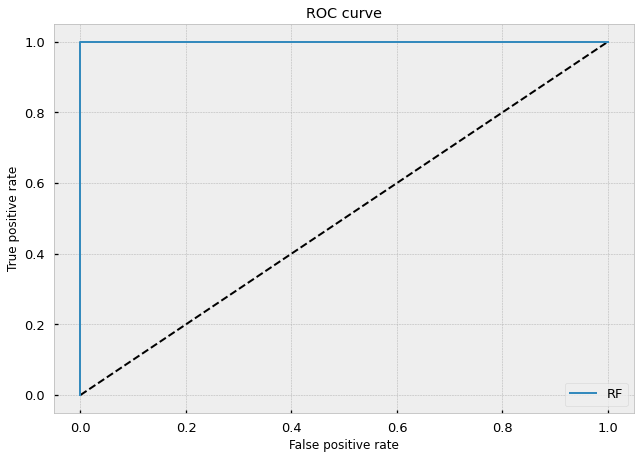

In [106]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Evaluating Secondary Model Testing Performance

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       484
           1       1.00      1.00      1.00       451

    accuracy                           1.00       935
   macro avg       1.00      1.00      1.00       935
weighted avg       1.00      1.00      1.00       935

Confusion Matrix
[[484   0]
 [  2 449]]

Accuracy
0.9978609625668449


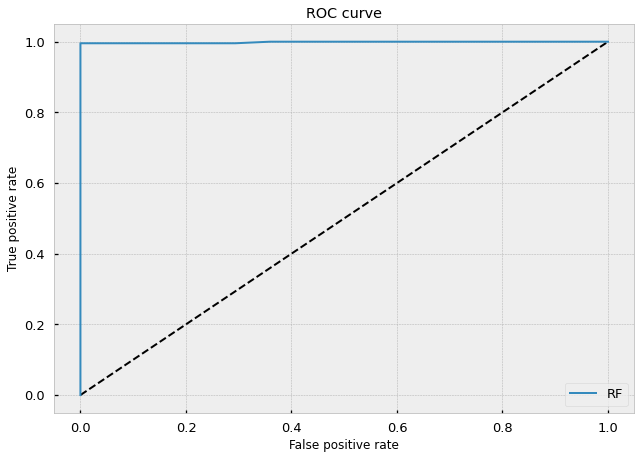

In [107]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [113]:
print(actual.head())

1970-01-17 17:50:34.380    1
1970-01-17 17:50:34.800    1
1970-01-17 17:50:35.220    1
1970-01-17 17:50:36.000    1
1970-01-17 17:50:36.180    1
Name: actual, dtype: int64


In [112]:
print(pred.head())

1970-01-17 17:50:34.380    1
1970-01-17 17:50:34.800    1
1970-01-17 17:50:35.220    1
1970-01-17 17:50:36.000    1
1970-01-17 17:50:36.180    1
Name: pred, dtype: int64


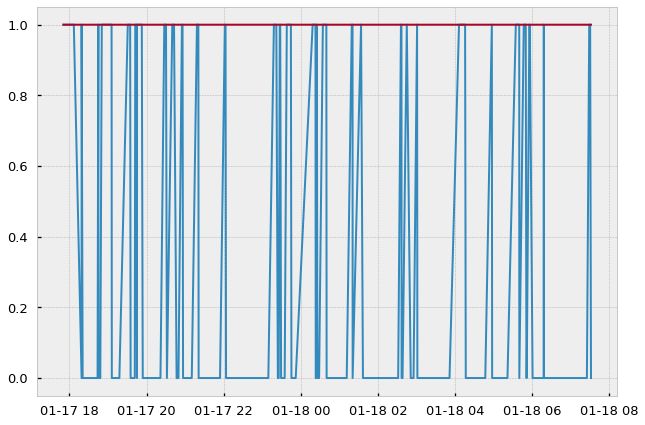

In [111]:
plt.figure(1)
plt.plot(actual)
plt.plot(pred)